In [20]:
import requests
import re
import pandas as pd
from urllib.parse import unquote, urlsplit 
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind


In [3]:
df_en= pd.read_csv('data/df_en.csv')

In [8]:
df_en['timestamp'] = pd.to_datetime(df_en['timestamp'],format='%Y%m%d%H')

In [9]:
df_en

,timestamp,Aesthetics,Agnosticism,Analytic philosophy,Anarchism,Anarchy,Animism,Asceticism,Atheism,Authoritarianism,...,Teleology,Theism,Theology,Thomism,Transhumanism,Utilitarianism,Vienna Circle,Vitalism,Zen,Zoroastrianism
0,2019-06-01,1456.0,2681.0,507.0,2176.0,1010.0,1277.0,1119.0,2274.0,949.0,...,551.0,649.0,918.0,325.0,1126.0,1738.0,202.0,350.0,1451.0,6305.0
1,2019-06-02,1627.0,3150.0,661.0,2909.0,1081.0,1494.0,1500.0,2771.0,1083.0,...,654.0,720.0,959.0,350.0,1239.0,2001.0,213.0,445.0,2934.0,8268.0
2,2019-06-03,1846.0,3419.0,600.0,2392.0,1134.0,1561.0,1376.0,2919.0,1152.0,...,749.0,702.0,1298.0,401.0,1255.0,2267.0,237.0,393.0,1685.0,6949.0
3,2019-06-04,1803.0,3655.0,677.0,2235.0,1119.0,1542.0,1257.0,3249.0,1352.0,...,700.0,783.0,1174.0,389.0,1580.0,2252.0,216.0,402.0,1747.0,5985.0
4,2019-06-05,2155.0,3175.0,670.0,2242.0,1137.0,1439.0,1351.0,2964.0,1214.0,...,797.0,694.0,2004.0,328.0,1331.0,2161.0,211.0,413.0,1822.0,5976.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,2020-12-28,2167.0,3421.0,753.0,3079.0,1229.0,1803.0,1786.0,2828.0,1383.0,...,651.0,709.0,1032.0,379.0,1680.0,1707.0,187.0,378.0,1813.0,6178.0
577,2020-12-29,2328.0,3153.0,770.0,3030.0,1210.0,1804.0,1735.0,2708.0,1460.0,...,669.0,709.0,1034.0,336.0,1594.0,1952.0,147.0,374.0,1877.0,5958.0
578,2020-12-30,3490.0,3110.0,994.0,3166.0,1364.0,1570.0,1651.0,2620.0,1638.0,...,681.0,665.0,968.0,359.0,2143.0,2034.0,178.0,399.0,1843.0,5941.0
579,2020-12-31,1838.0,2866.0,675.0,2912.0,1142.0,1547.0,1489.0,2398.0,1303.0,...,564.0,505.0,912.0,306.0,1663.0,1493.0,172.0,368.0,1587.0,5648.0


In [10]:
# Milestones dates : 
#First case
t0 = pd.to_datetime(2020021500,format='%Y%m%d%H')
#Mobility 
t1 = pd.to_datetime(2020031500,format='%Y%m%d%H')
#Normalcy 
t2 = pd.to_datetime(2020061500,format='%Y%m%d%H')

In [21]:
df_before = df_en[df_en['timestamp']<= t0]
df_t0t1 = df_en[(df_en['timestamp']<= t1) & (df_en['timestamp']>t0)]
df_t1t2 =df_en[(df_en['timestamp']<= t2) & (df_en['timestamp']>t1)]
df_after = df_en[df_en['timestamp']>t2]


## T-test for mean views between periods

Change change between in mean views between the periode beofre first case and the periode between 1st case and lockdown :

Aesthetics  : significant change


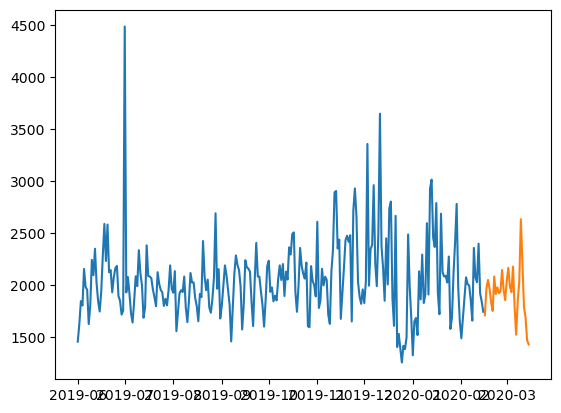

Agnosticism  : can not reject H0
Analytic philosophy  : significant change


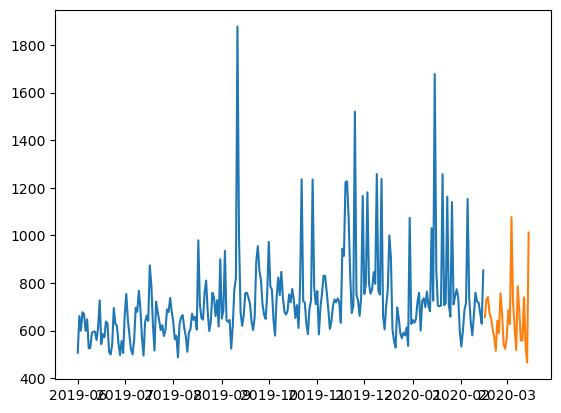

Anarchism  : can not reject H0
Anarchy  : can not reject H0
Animism  : can not reject H0
Asceticism  : can not reject H0
Atheism  : significant change


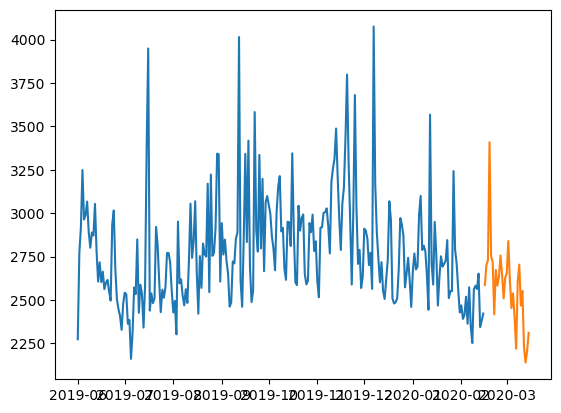

Authoritarianism  : significant change


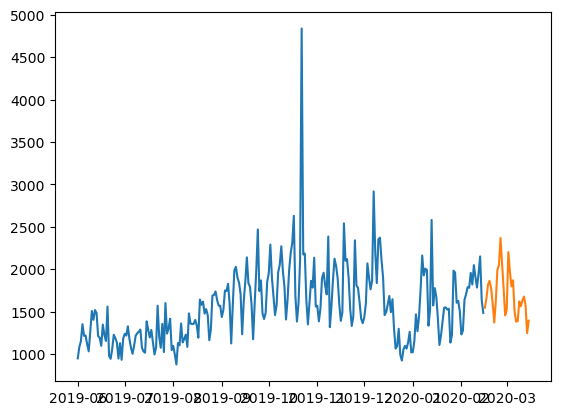

Baptism  : can not reject H0
Baptists  : significant change


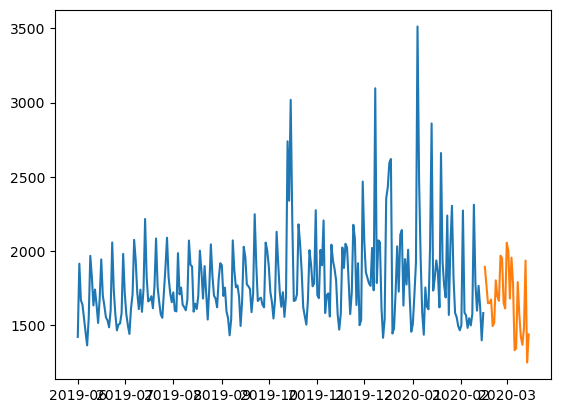

Behaviorism  : can not reject H0
Capitalism  : significant change


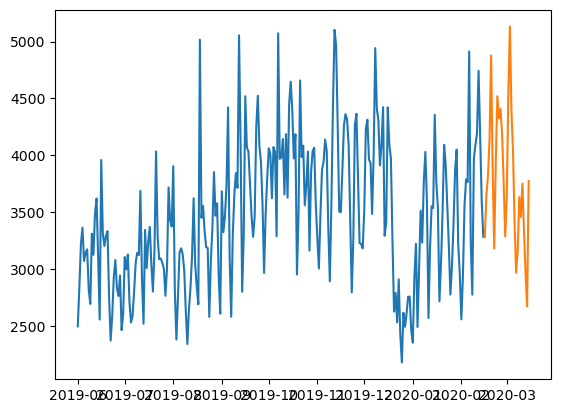

Categorical imperative  : significant change


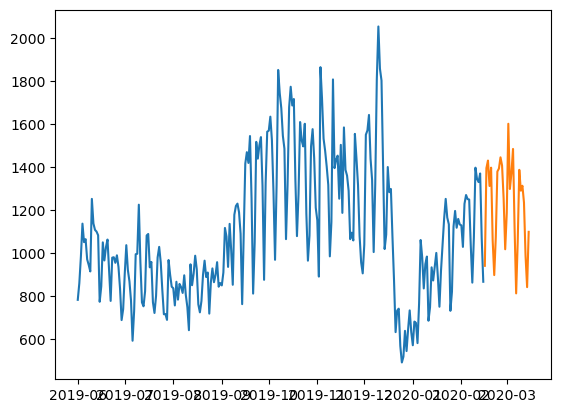

Communism  : significant change


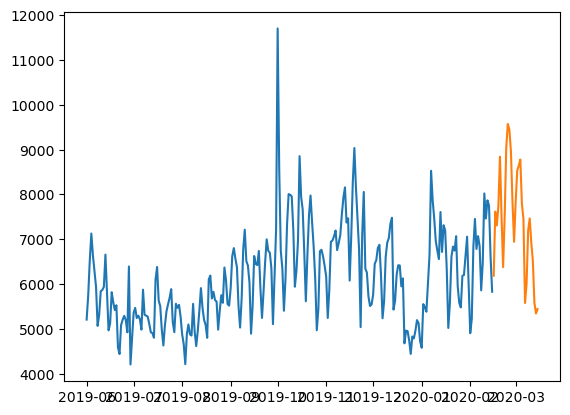

Confucianism  : can not reject H0
Consequentialism  : can not reject H0
Conservatism  : significant change


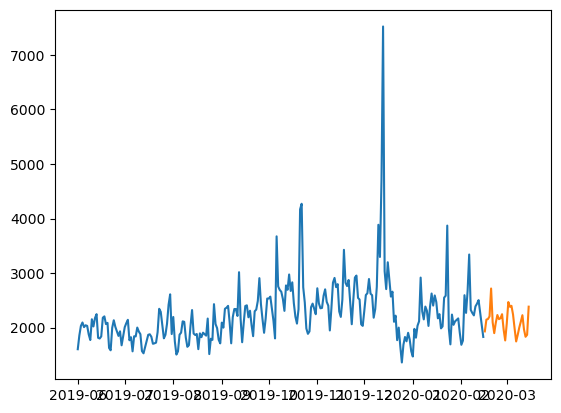

Continental philosophy  : significant change


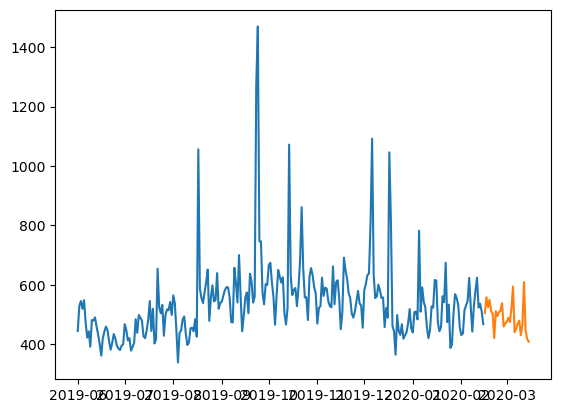

Critical theory  : can not reject H0
Cynicism (philosophy)  : significant change


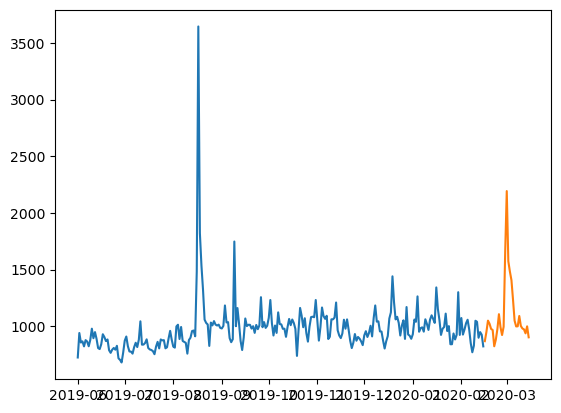

Deism  : significant change


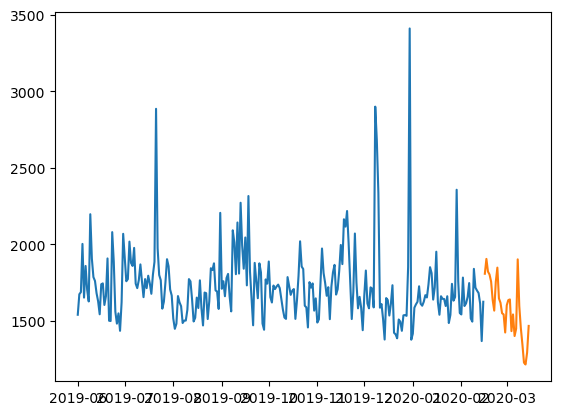

Determinism  : can not reject H0
Dialectic  : significant change


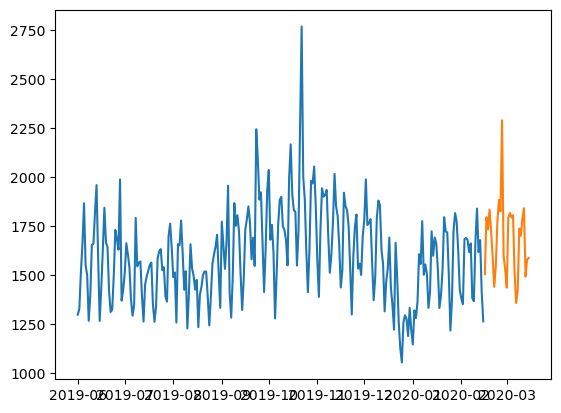

Dialectical materialism  : significant change


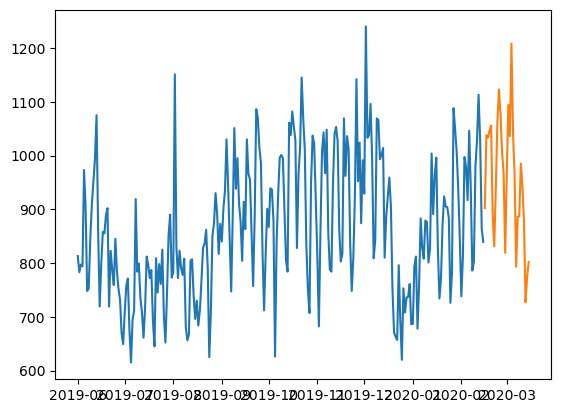

Ecumenism  : can not reject H0
Egalitarianism  : can not reject H0
Empiricism  : can not reject H0
Epistemology  : can not reject H0
Ethics  : significant change


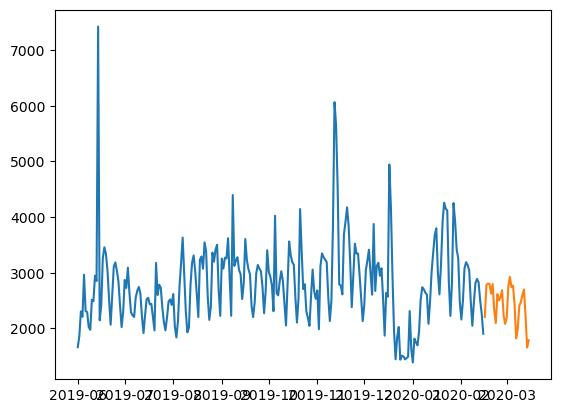

Existentialism  : significant change


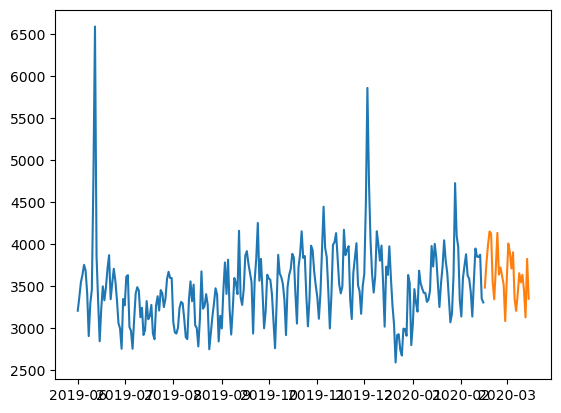

Fascism  : significant change


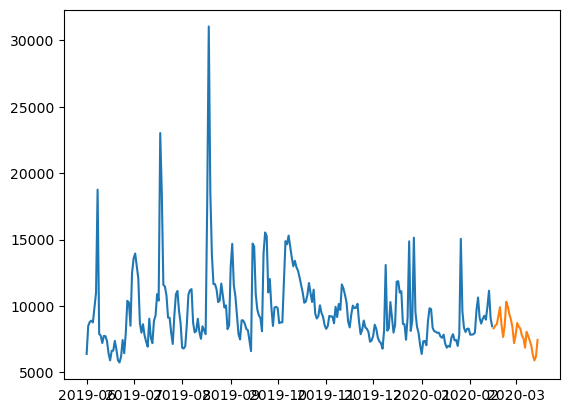

Fatalism  : significant change


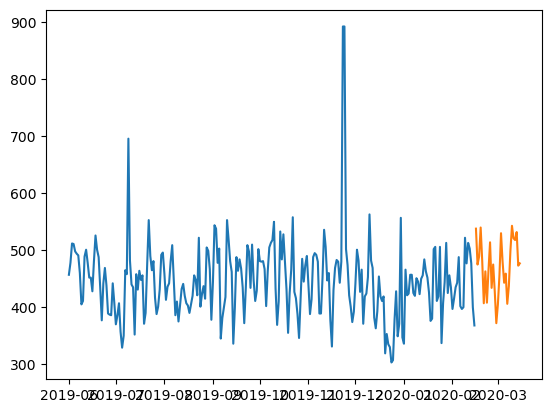

Feminist philosophy  : can not reject H0
Free will  : significant change


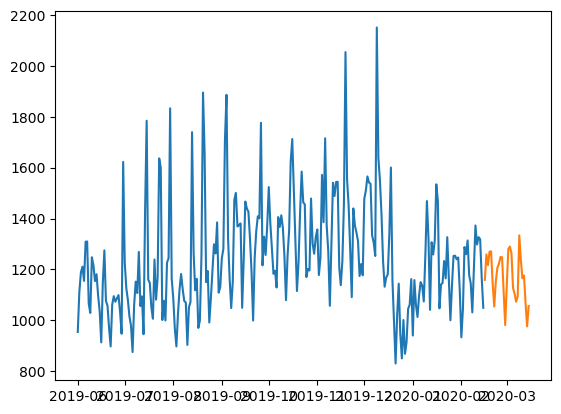

Fundamentalism  : can not reject H0
Gnosticism  : can not reject H0
Hedonism  : significant change


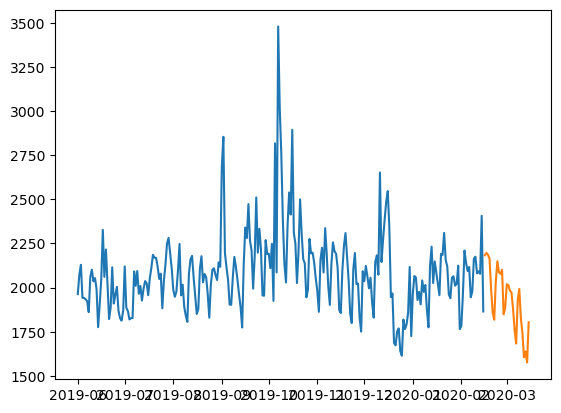

Henotheism  : can not reject H0
Hermeticism  : significant change


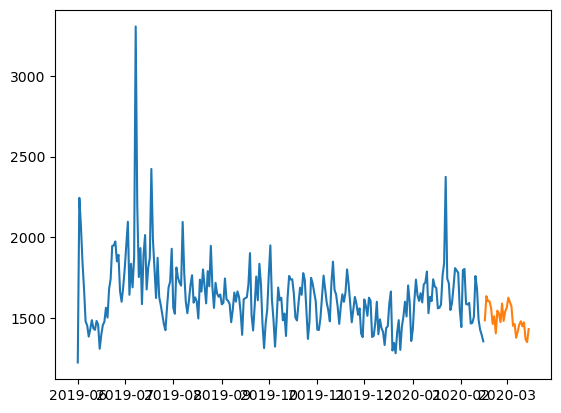

Historical materialism  : can not reject H0
Holism  : can not reject H0
Idealism  : can not reject H0
Individualism  : can not reject H0
Jainism  : significant change


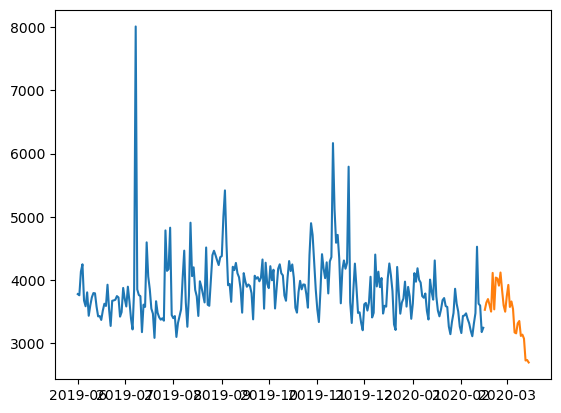

Juche  : significant change


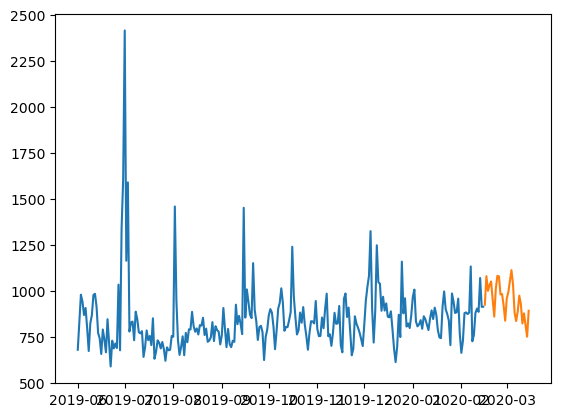

Kabbalah  : significant change


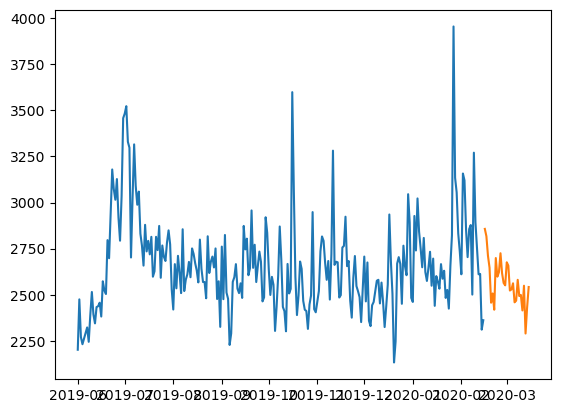

Leninism  : significant change


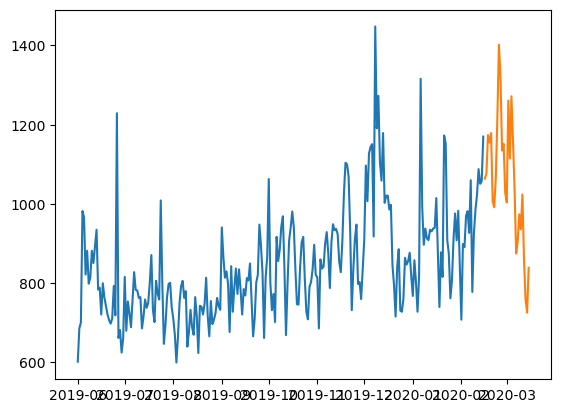

Liberalism  : can not reject H0
Libertarianism  : significant change


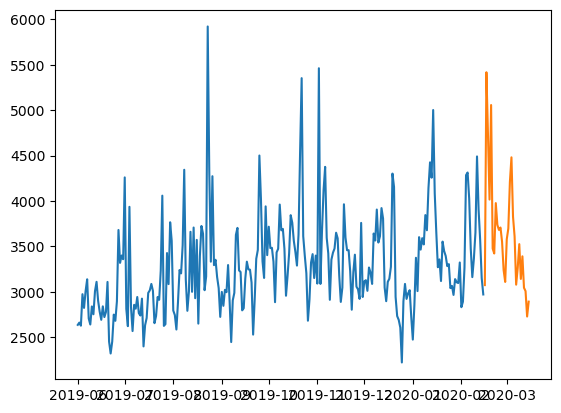

Logic  : can not reject H0
Logical positivism  : can not reject H0
Luddite  : can not reject H0
Manichaeism  : can not reject H0
Maoism  : significant change


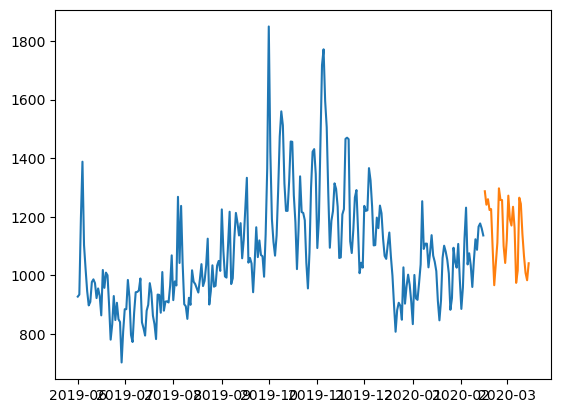

Marxism  : can not reject H0
Materialism  : can not reject H0
Medieval philosophy  : significant change


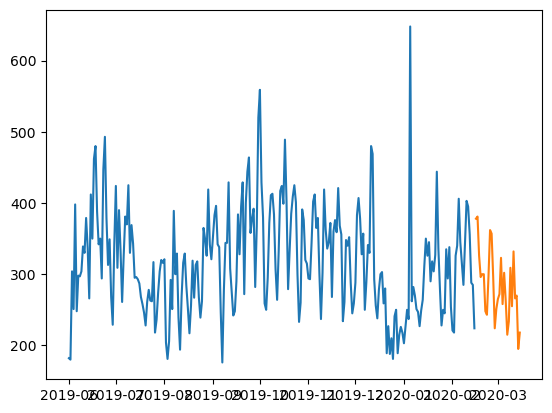

Metaphysics  : significant change


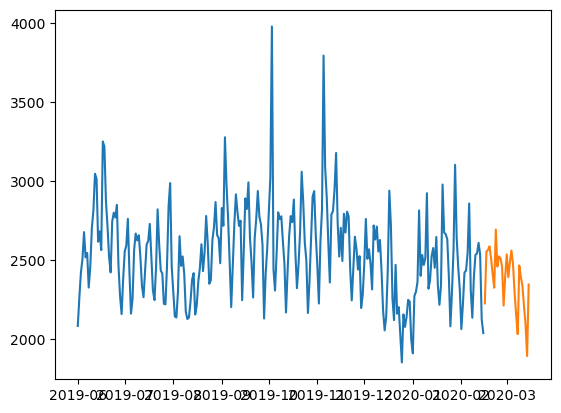

Monism  : can not reject H0
Mysticism  : significant change


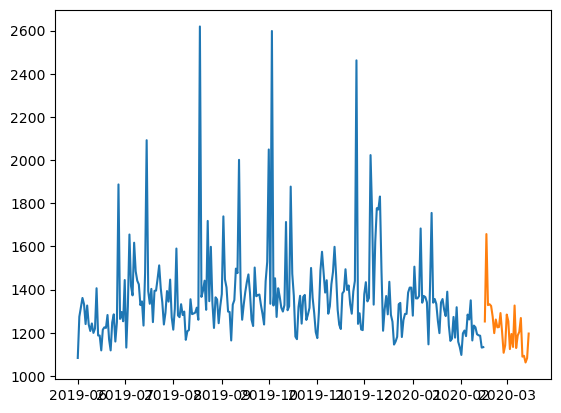

Nazism  : significant change


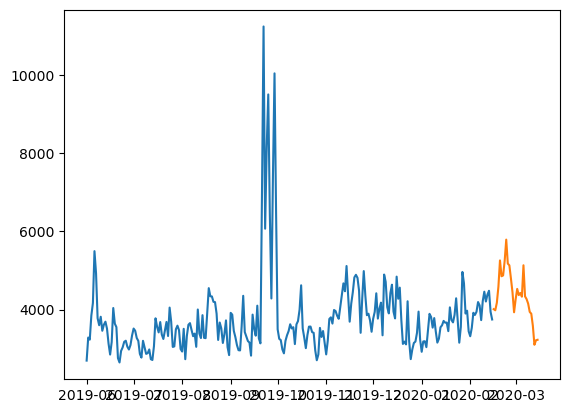

Neoliberalism  : significant change


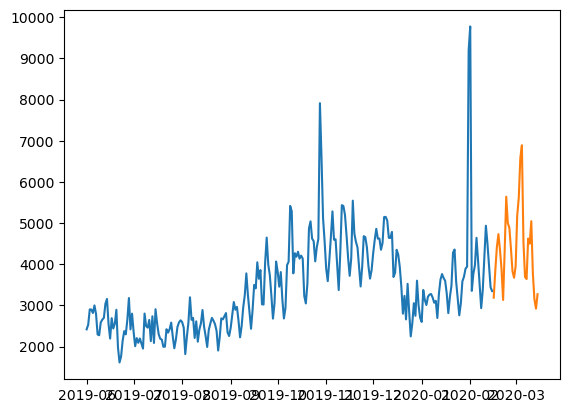

Neoplatonism  : can not reject H0
New Age  : significant change


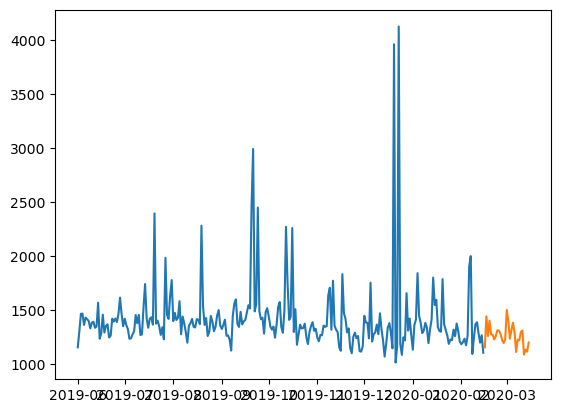

Nihilism  : can not reject H0
Ontology  : significant change


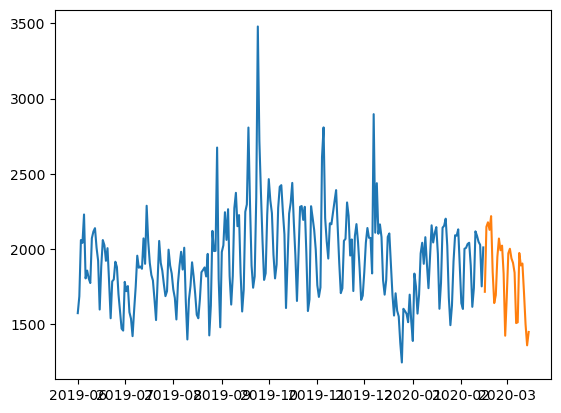

Paganism  : significant change


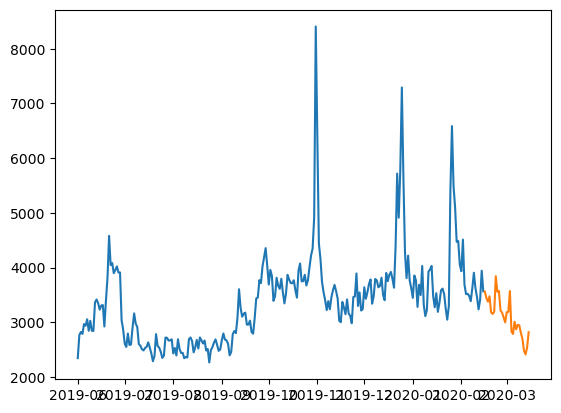

Pantheism  : significant change


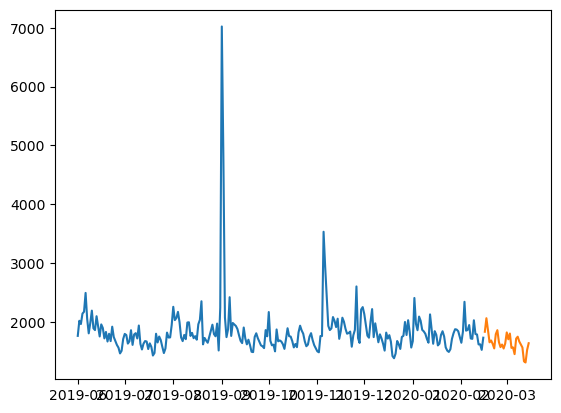

Personalism  : significant change


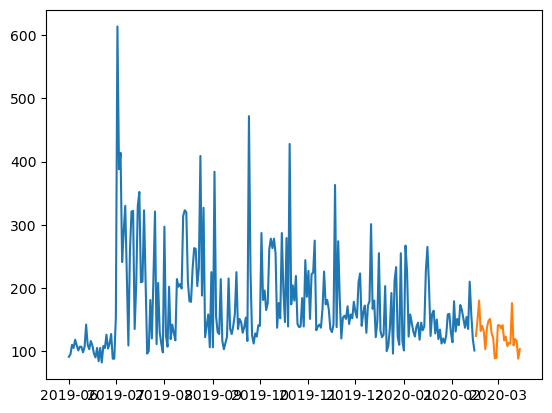

Phenomenology (philosophy)  : can not reject H0
Philosophical realism  : can not reject H0
Philosophy of language  : can not reject H0
Philosophy of law  : can not reject H0
Philosophy of mind  : can not reject H0
Philosophy of religion  : significant change


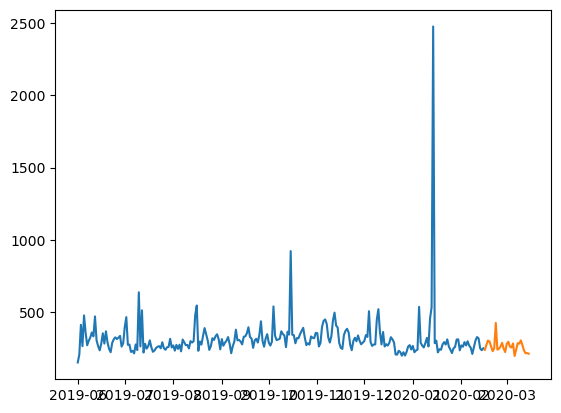

Philosophy of science  : significant change


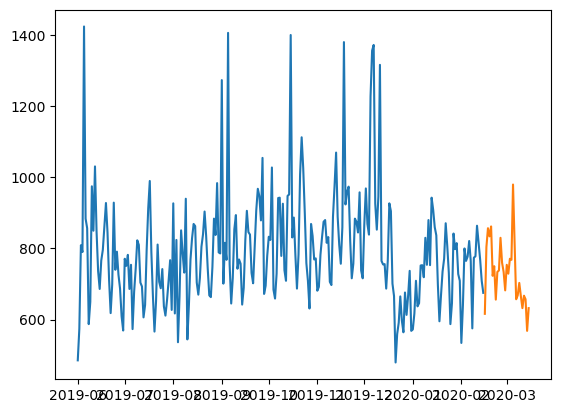

Platonism  : can not reject H0
Political philosophy  : can not reject H0
Populism  : can not reject H0
Positivism  : can not reject H0
Post-structuralism  : can not reject H0
Rastafari  : significant change


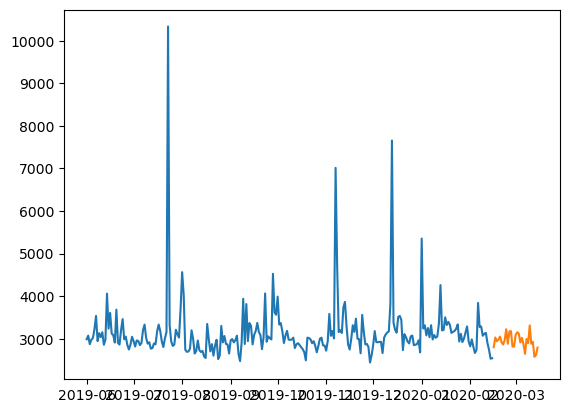

Rationalism  : can not reject H0
Reductionism  : can not reject H0
Relativism  : can not reject H0
Romanticism  : significant change


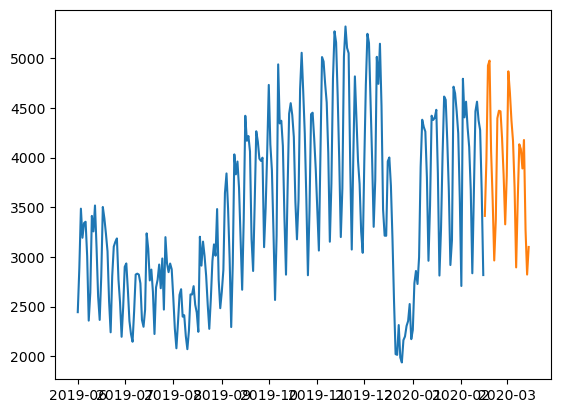

Satanism  : can not reject H0
Scholasticism  : significant change


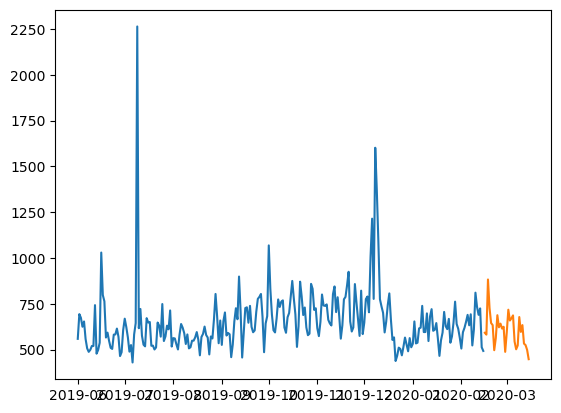

Scientism  : significant change


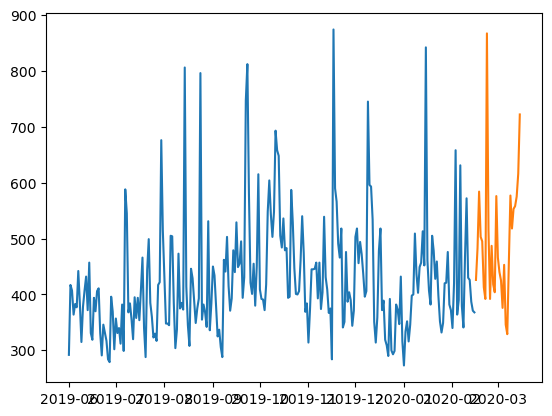

Shamanism  : significant change


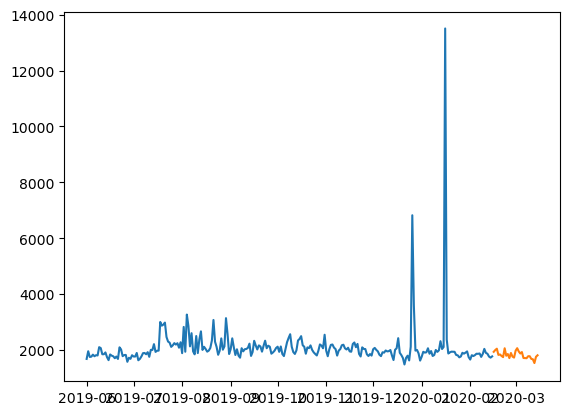

Sikhism  : significant change


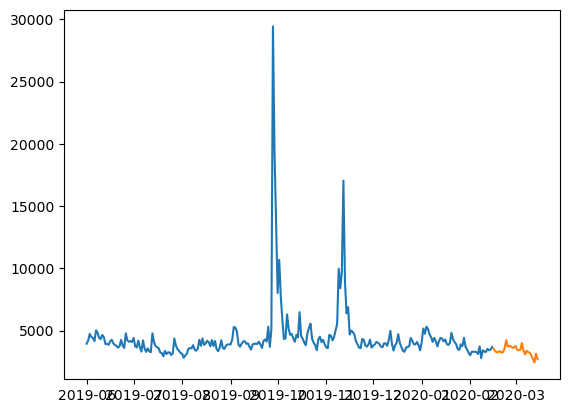

Socialism  : significant change


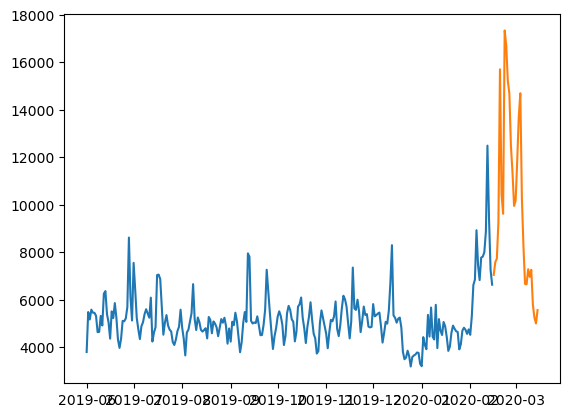

Socrates  : significant change


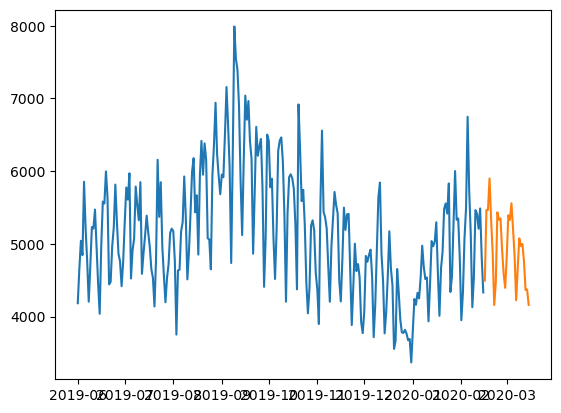

Stoicism  : can not reject H0
Structuralism  : can not reject H0
Taoism  : can not reject H0
Teleology  : can not reject H0
Theism  : significant change


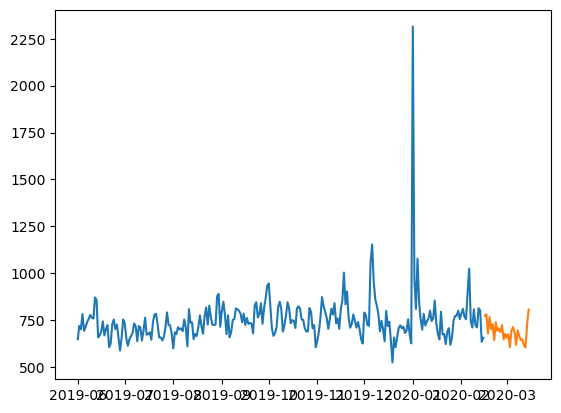

Theology  : significant change


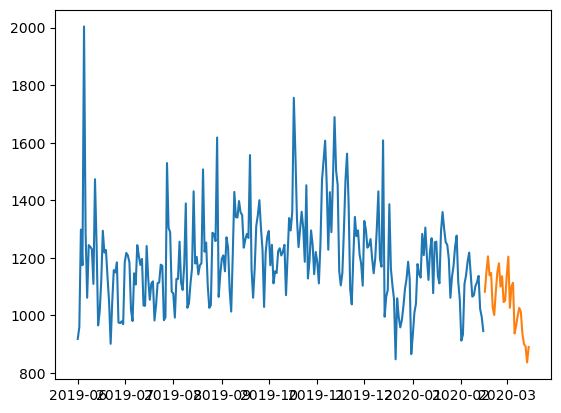

Thomism  : significant change


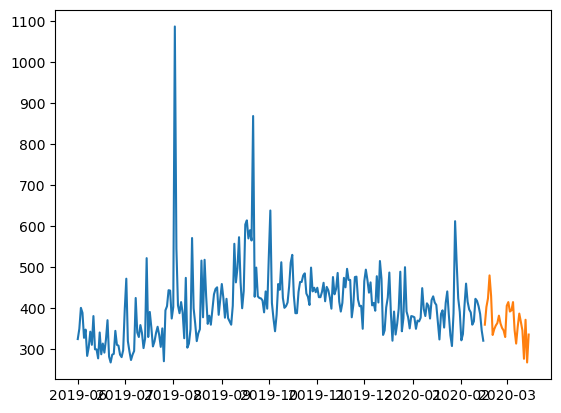

Transhumanism  : significant change


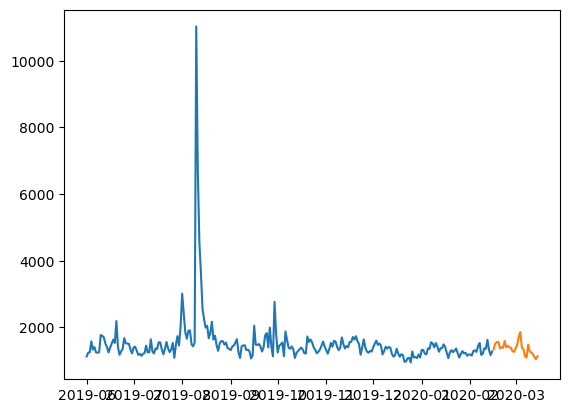

Utilitarianism  : significant change


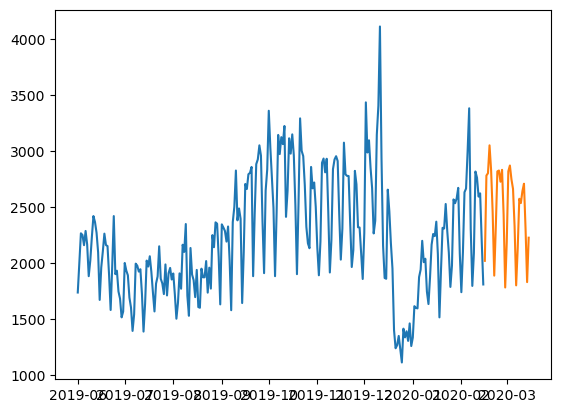

Vienna Circle  : significant change


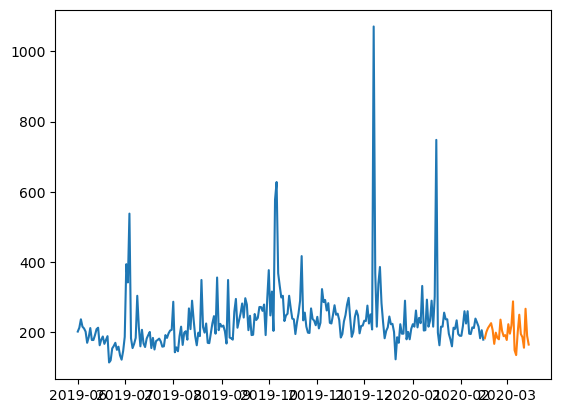

Vitalism  : can not reject H0
Zen  : significant change


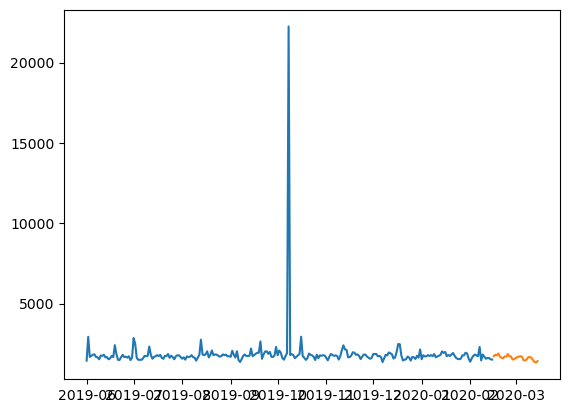

Zoroastrianism  : significant change


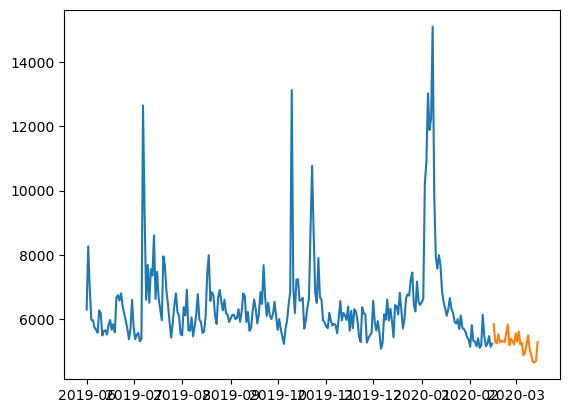

In [27]:
# Compare : before covid / between first case and lockdown 
articles = df_en.columns[1:]
print('Change change between in mean views between the periode beofre first case and the periode between 1st case and lockdown :\n')
for article in articles : 

    result = ttest_ind(df_before[article], df_t0t1[article], equal_var=False)
    if result.pvalue < 0.05 : 
        print(article, ' : significant change')
        plt.plot(df_before['timestamp'],df_before[article])
        plt.plot(df_t0t1['timestamp'],df_t0t1[article])
        plt.show()
    else :
        print( article, ' : can not reject H0')


### Test with trends and not means 